In [1]:
import os, sys
import numpy as np
from pathlib import Path

import scipy
from scipy import interpolate

from astropy.table import Table, Column, hstack, vstack, join
from astropy.io import fits, ascii

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.dpi"]  = 100
plt.rcParams["savefig.dpi"] = 200

sys.path.insert(0, "/global/cscratch1/sd/aberti")
from plotutils import get_corners

sys.path.insert(0, "/global/cscratch1/sd/aberti/SHAM/py")
from utils import *
from functions import sph_to_cart, load_cat, load_kcorr, get_patch_subs, get_survey_area #, make_cat, fmt_kcorr_idl
from masks import masks_from_maskbits, masks_from_fitbits, get_coord_mask, cat_geo_mask, extra_masks, desi_lrg_mask, desi_lrg_mask_optical
from params import BASEDIR, DATADIR, H0, Om0, zsnaps, get_abs_mag_lim

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
from astropy.constants import c as c_speed
from astropy import units as u


<a class="anchor" id="outline"></a>

* [Set parameters](#set_params)
* [Load data](#load_data)
* [Rest-frame magnitude vs photo-$z$ figure](#mag_fig)
* [Luminosity functions](#lum_func)
* [Color distributions (model vs data)](#color_dist_compare)
* [Color-magnitude diagrams](#cmd)
* [LRG statistics](#lrg_stats)
* [Color distributions](#color_dist)
* [Sky coverage figures](#sky_cover)
* [DOE figures](#doe)


In [2]:
settings = {
    "font.size": 16,
    "axes.linewidth": 1.0,
    "xtick.major.size": 6.0,
    "xtick.minor.size": 4.0,
    "xtick.major.width": 1.5,
    "xtick.minor.width": 1.0,
    "xtick.direction": "in", 
    "xtick.minor.visible": True,
    "xtick.top": True,
    "ytick.major.size": 6.0,
    "ytick.minor.size": 4.0,
    "ytick.major.width": 1.5,
    "ytick.minor.width": 1.0,
    "ytick.direction": "in", 
    "ytick.minor.visible": False,
    "ytick.right": True,
}

plt.rcParams.update(**settings)


In [3]:
def get_colors(N, c1="plasma", c2="viridis_r"):
    cm1 = plt.get_cmap(c1)
    cm2 = plt.get_cmap(c2)
    if N < 5:
        colors = [cm1((i+1/N)/N) for i in range(N)]
    else:
        c = np.concatenate([ [cm1(i/(N-1)) for i in range(N-1)], [cm2(i/(N-1)) for i in range(N)] ])
        if (N==5):
            colors = c[1:6]
        else:
            colors = [ c[int(i%len(c))] for i in range(len(c)) ][::2]
    return colors


### code for reading DECaLS catalog FITS files from NERSC

In [4]:
# fname = f"/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0/sweep-270p060-280p065.fits"

# hdu = fits.open(fname, mode="denywrite", memmap=True)

# t = Table(hdu[1].data)

# for i,col in enumerate(list(t.colnames)):
#     print(f"{i}\t{col}")


<a class="anchor" id="set_params"></a>
# Set parameters
Default magnitude limit is $m_z\leq21$

[BACK TO TOP](#outline)


In [5]:
d         = "south"
zrange    = (0.4,0.5)
zmin,zmax = np.round(zrange,1)
zphot_tag = "Z_PHOT_MEAN"
zkcorr    = None
zmag_lim  = 20.7

cat_tag  = get_cat_tag(d, zrange)
zmag_tag = get_zmag_tag(zmag_lim)

# zmin = 0.2 (r and W1): not enough optical LRGs (IR LRGs OK)
# zmin > 0.6: would need to relax z-band limit; mz < 21 not enough of an improvement

Mr_lim  = get_abs_mag_lim(zmin, "Mr")
Mz_lim  = get_abs_mag_lim(zmin, "Mz")
MW1_lim = get_abs_mag_lim(zmin, "MW1")

if Mr_lim==None:  Mr_lim = get_abs_mag_lim(0.6, "Mr")
if Mz_lim==None:  Mz_lim = get_abs_mag_lim(0.6, "Mz")
if MW1_lim==None: MW1_lim = get_abs_mag_lim(0.6, "MW1")

print(f"zrange:  {zrange}")

print(f"Mr_lim:  {Mr_lim}")
print(f"Mz_lim:  {Mz_lim}")
print(f"MW1_lim: {MW1_lim}")



zrange:  (0.4, 0.5)
Mr_lim:  -20.8
Mz_lim:  -21.6
MW1_lim: -22.25


<a class="anchor" id="load_data"></a>
# Load DECaLS DR9 data by north/south region and photo-$z$ bin

[BACK TO TOP](#outline)


In [6]:
%%time

# del cat
cat = load_cat(d=d, zrange=zrange, zphot_tag=zphot_tag)


Loading /global/cscratch1/sd/aberti/data/cat_z0p40-0p50_south.npy...
Cleaning up...
+/-150 Mpc/h	: 59197084
0.4 < z < 0.5	: 32757729
CPU times: user 1min 38s, sys: 1min 16s, total: 2min 55s
Wall time: 2min 56s


## Apparent magnitudes

In [7]:
mg  = 2.5*( 9 - np.log10(cat["FLUX_G"]/cat["MW_TRANSMISSION_G"]) )
mr  = 2.5*( 9 - np.log10(cat["FLUX_R"]/cat["MW_TRANSMISSION_R"]) )
mz  = 2.5*( 9 - np.log10(cat["FLUX_Z"]/cat["MW_TRANSMISSION_Z"]) )
mW1 = 2.5*( 9 - np.log10(cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) )


/tmp/ipykernel_48384/3453194152.py:4: RuntimeWarning: divide by zero encountered in log10
  mW1 = 2.5*( 9 - np.log10(cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) )
/tmp/ipykernel_48384/3453194152.py:4: RuntimeWarning: invalid value encountered in log10
  mW1 = 2.5*( 9 - np.log10(cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) )


## Define select data masks

In [8]:
#-- z-band apparent mag cut
zmag_mask = (mz <= zmag_lim)

#-- photo-z cut
zphot      = cat[zphot_tag]
zphot_mask = (zphot >= zmin) & (zphot < zmax)

#-- geometric mask (also assigns jackknife regions to catalog)
cat, geo_mask = cat_geo_mask(cat, plot=False)


Assigning jackknife patches (SOUTH)...
Getting data catalog masks...
0.928	Sky contamination
0.768	Stars
0.941	RA/Dec cuts to match randoms
0.683	All combined


## Apply masks to catalog, photo-$z$s, apparent magnitudes

In [9]:
all_mask = geo_mask & zmag_mask & zphot_mask

cat   = cat[all_mask]
zphot = zphot[all_mask]

mg  = mg[all_mask]
mr  = mr[all_mask]
mz  = mz[all_mask]
mW1 = mW1[all_mask]

mx = np.array([mg, mr, mz, mW1])


## Load K-corrections and estimate absolute magnitudes from photo-$z$s

In [10]:
%%time

#-- simulation redshifts for data ranges; keys are data zmin
snaps = {}
for i in np.arange(0,10,1):
    snaps[round(0.1*i,1)] = zsnaps[int(i)]
assert( (zmax > zmin) & (zmin in snaps.keys()) )

if (zkcorr=="zsnap") | (zkcorr==None):
    zkcorr = snaps[zmin]

print(f"K-correction redshift set to {zkcorr}")

#-- load K-corrections
Kx_all = load_kcorr(d=d, zrange=zrange, zkcorr=zkcorr, quiet=False)
Kx     = np.array([k[all_mask] for k in Kx_all[:-1]])
Kg, Kr, Kz, KW1 = Kx

print("Estimating absolute magnitudes...")

DM = cosmo.distmod(zphot.data).value

Mg  = mg - DM - Kg
Mr  = mr - DM - Kr
Mz  = mz - DM - Kz
MW1 = mW1 - DM - KW1

Mx = np.array([Mg, Mr, Mz, MW1])



K-correction redshift set to 0.43152
Loading K-corrections...
Estimating absolute magnitudes...
CPU times: user 28.9 s, sys: 3.56 s, total: 32.5 s
Wall time: 32.6 s


<a class="anchor" id="mag_fig"></a>
# Rest-frame magnitude vs photo-$z$ figure

[BACK TO TOP](#outline)


In [11]:
# temp = Table(data=[Mg,Mr,Mz,MW1,zphot], names=("Mg","Mr","Mz","MW1","zphot")) 
# np.save(f"{BASEDIR}/abs_mags_{cat_tag}", temp)


In [12]:
# t = Table(np.load(f"abs_mags_z0p40-0p50_south.npy"))

# Mr_all    = t["Mr"]
# MW_all    = t["MW1"]
# zphot_all = t["zphot"]


In [13]:
# DS = 100
# zz = (0.4,0.5,0.6,0.7)
# fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# kwargs = dict(s=2, color="gray", alpha=0.02)
# line_kwargs = dict(color="orangered", lw=2)

# ylims = ((-19.9,-22.5), (-21.3,-24.5))

# for idx,ax,b,mags,dmag,nbins,ylim in zip(range(3),axes,("Mr","MW1"),(Mr_all,MW_all),(0.2,0.3),((6,5,3),(4,4,4)),ylims):
#     ax.set_xlim(0.398,0.702)
#     ax.set_ylim(ylim)
#     ax.hexbin(zphot_all[::DS], mags[::DS], cmap="gray_r", gridsize=(500,500), bins="log")#, **kwargs)
    
#     # divs = [(i*np.ones(2), ax.get_ylim()) for i in zz]
#     # for l in divs:
#     #     ax.plot(*l, color="orange", ls="--", lw=1.5)

#     hlines = [[(i,i+0.1), get_abs_mag_lim(i,b)*np.ones(2)] for i in zz[:-1]]
#     vlines = [[i*np.ones(2), (get_abs_mag_lim(np.round(i-0.1,1),b),ax.get_ylim()[1])] for i in zz]
#     ax.plot(vlines[0][0], vlines[1][1], **line_kwargs)
#     for j in vlines[1:]:
#         ax.plot(*j, **line_kwargs)
#     for h,nbin in zip(hlines,nbins):
#         if (b=="Mr") and (idx==2):
#             nbin = 6
#         for k in range(nbin+1):
#             ax.plot(h[0],h[1]-dmag*k, **line_kwargs)
        
# axes[0].set_yticks(np.arange(-20,-22.6,-0.5))
# axes[0].set_ylabel(r"${\rm rest}$-${\rm frame}\ M_{\rm r}$", fontsize=22)
# axes[1].set_yticks(np.arange(-21.5,-24.6,-0.5))
# axes[1].set_ylabel(r"${\rm rest}$-${\rm frame}\ M_{\rm W1}$", fontsize=22)
# axes[1].set_xlabel(r"$z_{\rm phot}$", fontsize=24)

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)

# figname = "figures/abs_mag_bins_vs_zphot_z0p4-0p7.png"
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1)

# plt.show()


<a class="anchor" id="lum_func"></a>
# Generate and save luminosity functions for SHAM magnitude assignment

[BACK TO TOP](#outline)


In [14]:
# lrg_mask_opt = desi_lrg_mask_optical( cat )
# lrg_mask_IR  = desi_lrg_mask( cat )

# print(len(cat[lrg_mask_IR]))
# print(len(cat[lrg_mask_opt]))


In [15]:
# colors = get_colors(2)

# bins = np.linspace(-25,-21.4,100)

# fig, ax = plt.subplots(1, 1)

# ax.hist(Mz, bins=bins, color="gray", alpha=0.5)
# ax.plot((Mz_lim,Mz_lim), ax.get_ylim(), "k")

# ax.hist(Mz[lrg_mask_opt], bins=bins, color=colors[1], alpha=1, label="optical selection")
# ax.hist(Mz[lrg_mask_IR], bins=bins, color=colors[0], alpha=0.4, label="IR selection")

# print(100*len(Mz[lrg_mask_opt & (Mz > Mz_lim)])/len(Mz[lrg_mask_opt]))
# print(100*len(Mz[lrg_mask_IR & (Mz > Mz_lim)])/len(Mz[lrg_mask_IR]))

# ax.set_xlim(-25,-21)
# #ax.set_ylim(0,1e6)

# ax.legend()

# plt.show()


In [16]:
# dm = 0.25

# bins = np.concatenate([[Mz_lim-dm*i for i in range(4)],[-30]])[::-1]
# print(bins)

# counts,_ = np.histogram(Mz, bins=bins)

# counts/np.min(counts)


In [17]:
abs_mag_lims = {"Mr":Mr_lim, "Mz":Mz_lim, "MW1":MW1_lim}
abs_mag_bins = np.arange(-16,-25.01,-0.05)
plot         = False
save         = True
# abs_mag_cut  = True


### Specify band (Mr / Mz / MW1)

In [18]:
%%time

band = "Mz"
abs_mag_lim = abs_mag_lims[band]

lrg_mask_opt = desi_lrg_mask_optical( cat )
lrg_mask_IR  = desi_lrg_mask( cat )

if band=="Mr":
    m = mr
    K = Kr
    M = Mr
    abs_mag_tag = get_Mr_tag(abs_mag_lim)
elif band=="Mz":
    m = mz
    K = Kz
    M = Mz
    abs_mag_tag = get_Mz_tag(abs_mag_lim)
elif band=="MW1":
    m = mW1
    K = KW1
    M = MW1
    abs_mag_tag = get_MW1_tag(abs_mag_lim)

colors = get_colors(2)
    
for abs_mag_cut in (True,False):
    if abs_mag_cut:
        abs_mag_mask = (M <= abs_mag_lim)
    else:
        abs_mag_mask = np.ones(len(M), dtype=bool)

    #-- grz DESI depth requirements: 24.0, 23.4, 22.5
    #-- Rongpu reliable photo-z cut: apparent z-band mag < 21.0

    #-- effective sample number density
    areas = get_survey_area(masked=True) #-- (area_north_masked, area_south_masked)
    area  = areas[0] if d=="north" else areas[1]

    app_mag_min = np.nanmax(m)

    print(f"{band[1:]}-band apparent magnitude min = {app_mag_min:.2f}")
    dlum_Mpc_max = (10.**( -5. + ( app_mag_min - M - K )/5. ))[abs_mag_mask]

    zz = np.arange(0, 500, 0.01)
    dlum_Mpc = cosmo.luminosity_distance(zz).value
    z_of_dlum_Mpc = interpolate.interp1d(dlum_Mpc, zz, fill_value="extrapolate")

    V_zphot  = (cosmo.comoving_volume(zphot.data) - cosmo.comoving_volume(zmin)).value
    zmin_eff = zmin
    zmax_eff = np.array([ np.min([ zmax,x ]) for x in z_of_dlum_Mpc(dlum_Mpc_max) ])
    V_eff    = (cosmo.comoving_volume(zmax_eff) - cosmo.comoving_volume(zmin_eff)).value

    abs_mag_hist,_ = np.histogram(M, bins=abs_mag_bins[::-1])
    gal_counts     = np.cumsum(abs_mag_hist)

    ng_eff = [np.sum( 1./(area*V_eff[M[abs_mag_mask] < mm]) ) for mm in abs_mag_bins]

    out = dict( V_zphot=V_zphot, V_eff=V_eff, abs_mag_bins=abs_mag_bins[::-1], ng_eff=ng_eff, gal_counts=gal_counts )

    if plot:
        rcParams["font.family"] = "serif"
        rcParams["mathtext.fontset"] = "dejavuserif"

        fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True)#, sharey=True)
        for ax in axes:
            ax.tick_params(axis="both", which="major", labelsize=12)
            ax.tick_params(axis="x", rotation=45)
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        ax = axes[0]
        if band=="Mr":
            ax.set_xlim(-24,-19)
            ax.set_xticks(np.arange(-24,-18.5,0.5))
            loc = 2
        elif band=="Mz":
            ax.set_xlim(-24.5,-19.5)
            ax.set_xticks(np.arange(-24.5,-19,0.5))
            loc = 2
        elif band=="MW1":
            ax.set_xlim(-25,-20)
            ax.set_xticks(np.arange(-25,-19.5,0.5))
            loc = 1

        ax.set_xlabel(f"${band}$ (rest frame)", fontsize=14)
        bins = abs_mag_bins[::-1]
        ax.hist(M, bins=bins, color="gray", alpha=0.4, label="$z$-band cut only", density=True)
        ax.hist(M[(M <= abs_mag_lim)], bins=bins, histtype="step", color="black", lw=1.5, label=f"+ ${band}$ cut", density=True)
        ax.hist(M[lrg_mask_opt], bins=bins, color=colors[0], alpha=0.5, label=f"Optical LRG", density=True)
        ax.hist(M[lrg_mask_IR], bins=bins, color=colors[1], alpha=0.6, label=f"IR LRG", density=True)
        ax.legend(loc=loc, fontsize=12, handletextpad=0.5)

        ax = axes[1]
        ax.set_xlabel(axes[0].get_xlabel(), fontsize=14)
        ax.set_ylabel(r"$n_{\rm gal}(\!<$" + f"${band}$" + r"$)\ [h^3\ {\rm Mpc}^{-3}]$", fontsize=14)
        ax.plot(abs_mag_bins, ng_eff, lw=1.5, color="black")

        txt = f"${zmin:.1f}<z$" + r"$_{\rm phot}$" + f"$<{zmax:.1f}$" + f"\n{d.upper()}"
        ax.text(*get_corners(ax)["upper_left"], txt, fontsize=14, ha="left", va="top")

        plt.tight_layout()
        # figname = f"{BASEDIR}/figures/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_tag}.png"
        # print(f"Saving plot as {figname}...")
        # plt.savefig(figname, bbox_inches="tight", pad_inches=0.1)
        plt.show()

    if save:
        if abs_mag_cut:
            out_fname = f"{BASEDIR}/luminosity_functions/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_tag}.npy"
        else:
            out_fname = f"{BASEDIR}/luminosity_functions/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy"
        print(f"Saving as {out_fname}...")
        np.save(out_fname, out)


/global/cscratch1/sd/aberti/SHAM/py/masks.py:60: RuntimeWarning: invalid value encountered in log10
  W1 = 2.5*( 9 - np.log10(cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) )
/global/cscratch1/sd/aberti/SHAM/py/masks.py:23: RuntimeWarning: invalid value encountered in log10
  W1 = 2.5*( 9 - np.log10(cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) )


z-band apparent magnitude min = 20.70
Saving as /global/cscratch1/sd/aberti/SHAM/luminosity_functions/lum_func_Mz_z0p40-0p50_south_zmaglim20p7_Mzlimn21p6.npy...
z-band apparent magnitude min = 20.70
Saving as /global/cscratch1/sd/aberti/SHAM/luminosity_functions/lum_func_Mz_z0p40-0p50_south_zmaglim20p7_full.npy...
CPU times: user 5min 26s, sys: 50.4 s, total: 6min 16s
Wall time: 6min 16s


<a class="anchor" id="color_dist_compare"></a>
# Color distributions (model vs data)

[BACK TO TOP](#outline)

### Rest-frame colors

In [19]:
# g_r  = (mg - Kg) - (mr - Kr)
# g_W1 = (mg - Kg) - (mW1 - KW1)

r_z  = (mr - Kr) - (mz - Kz)
r_W1 = (mr - Kr) - (mW1 - KW1)


In [20]:
# bins = np.linspace(1.6,2)

# plt.hist(r_z, bins=bins)
# plt.hist(r_z[Mz < Mz_lim], bins=bins)

# plt.show()


In [21]:
# %%time

# scatter_tag = "scatter-lin-chisq1"

# lrg_mask_opt = desi_lrg_mask_optical(cat)
# lrg_mask_IR  = desi_lrg_mask(cat)

# if zmin==0.4:
#     fname_Mr  = f"zsnap0p42531_zmaglim20p7_Mrlimn20p8_{scatter_tag}_galcat_LRG-flagged.npy"
#     fname_MW1 = f"zsnap0p42531_zmaglim20p7_MW1limn22p25_{scatter_tag}_galcat_LRG-flagged.npy"
# elif zmin==0.5:
#     fname_Mr  = f"zsnap0p52323_zmaglim20p7_Mrlimn20p8_{scatter_tag}_galcat_LRG-flagged.npy"
#     fname_MW1 = f"zsnap0p52323_zmaglim20p7_MW1limn22p85_{scatter_tag}_galcat_LRG-flagged.npy"
# elif zmin==0.6:
#     fname_Mr  = f"zsnap0p62813_zmaglim20p7_Mrlimn21p0_{scatter_tag}_galcat_LRG-flagged.npy"
#     fname_MW1 = f"zsnap0p62813_zmaglim20p7_MW1limn23p15_{scatter_tag}_galcat_LRG-flagged.npy"
# else:
#     raise Exception()

# mock_Mr  = Table(np.load(f"{BASEDIR}/mocks/{fname_Mr}"))
# mock_MW1 = Table(np.load(f"{BASEDIR}/mocks/{fname_MW1}"))
                

In [22]:
# fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# colors = get_colors(2)
# ymax   = 0

# def _get_heights(data, bins):
#     heights, cens = np.histogram(data, bins=bins)
#     heights = heights/sum(heights)
#     cens    = 0.5*(cens[:-1] + cens[1:])
#     return heights, cens

# for ax,band in zip(axes,("W1","r")):
#     if band=="r":
#         mag = Mr
#         mag_lim = Mr_lim
#         bins = np.arange(0.2,2.301,0.025)
#         bins_model = np.arange(0.2,2.301,0.05)
#         cc = g_r
#         mock = mock_Mr
#     elif band=="W1":
#         mag = MW1
#         mag_lim = MW1_lim
#         bins = np.arange(1.5,5.55,0.05)
#         bins_model = np.arange(1.5,5.55,0.1)
#         cc = g_W1
#         mock = mock_MW1
#     else:
#         raise Exception()

#     color_key = f"g-{band}"
    
#     #-- DATA --#
#     heights, cens = _get_heights(cc[mag <= mag_lim], bins)
#     hmax = np.max(heights)
#     if ymax < hmax: ymax = hmax
#     ax.fill_between(cens, heights, alpha=0.2, color="gray", label="data")

#     #-- OPTICAL LRG --#
#     heights, cens = _get_heights(cc[(mag <= mag_lim) & lrg_mask_opt], bins)
#     hmax  = np.max(heights)
#     scale = len(cc[(mag <= mag_lim) & lrg_mask_opt])/len(cc[mag <= mag_lim])
#     if ymax < scale*hmax: ymax = scale*hmax
#     ax.fill_between(cens, scale*heights, color="k", lw=1, alpha=0.5, facecolor="none", hatch="////", label="optical LRG (data)")

#     #-- IR LRG --#
#     heights, cens = _get_heights(cc[(mag <= mag_lim) & lrg_mask_IR], bins)
#     hmax  = np.max(heights)
#     scale = len(cc[(mag <= mag_lim) & lrg_mask_IR])/len(cc[mag <= mag_lim])
#     if ymax < scale*hmax: ymax = scale*hmax
#     ax.fill_between(cens, scale*heights, color=colors[0], alpha=0.3, label="IR LRG (data)")

#     #-- MOCK --#
#     heights, cens = _get_heights(mock[color_key], bins=bins_model[::2])
#     ax.plot(cens, heights/4, color="k", ls=":", lw=2, label="model")

#     #-- MOCK OPTICAL LRG --#
#     heights, cens = _get_heights(mock[color_key][mock[f"LRG_opt"]==True], bins=bins_model)
#     scale = (len(mock[mock["LRG_opt"]==True])/len(mock))/2
#     ax.plot(cens, scale*heights, color=colors[1], ls="--", lw=3, label="optical LRG (model)")
    
#     #-- MOCK IR LRG --#
#     heights, cens = _get_heights(mock[color_key][mock[f"LRG_IR"]==True], bins=bins_model)
#     scale = (len(mock[mock["LRG_IR"]==True])/len(mock))/2
#     ax.plot(cens, scale*heights, color=colors[0], ls="dashdot", lw=3, label="IR LRG (model)")
    
#     ax.set_xlim(np.min(bins),np.max(bins))
#     ax.set_xlabel(f"$g-{band}$" + r"$\ ({\rm rest}$-${\rm frame})$")
    
# axes[0].set_xticks(np.arange(*axes[0].get_xlim(),0.5))
# axes[0].set_ylim(0,1.05*ymax)
# axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# txt = f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$"
# axes[1].text(*get_corners(axes[1], margin=0.05)["upper_left"], txt, ha="left", va="top", fontsize=20)
# axes[0].legend(frameon=False, loc=2, handletextpad=0.5, labelspacing=0.25)

# plt.tight_layout()

# figname = f"{BASEDIR}/figures/color_compare_data_vs_model_{cat_tag}.png"
# print(figname)
# # fig.savefig(figname, bbox_inches="tight", pad_inches=0.1)

# plt.show()


<a class="anchor" id="cmd"></a>
# Data color-magnitude diagrams

[BACK TO TOP](#outline)

### Specify band (r/W1) and LRG selection (optical/IR)

Mz	IR LRG selection


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4797: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/matplotlib/ticker.py:2788: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


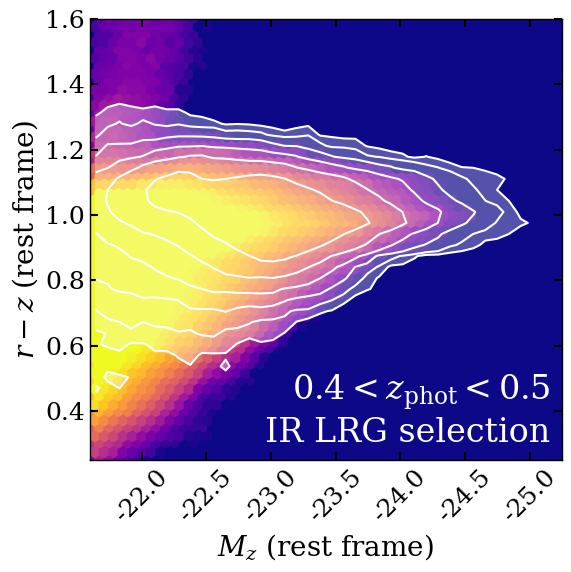

Mz	optical LRG selection


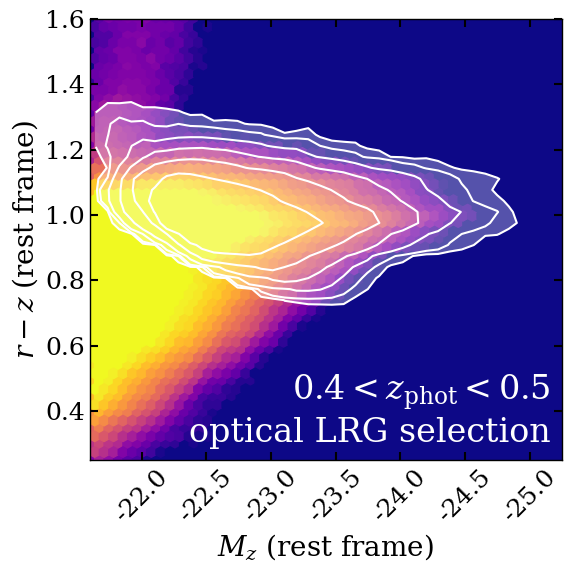

MW1	IR LRG selection


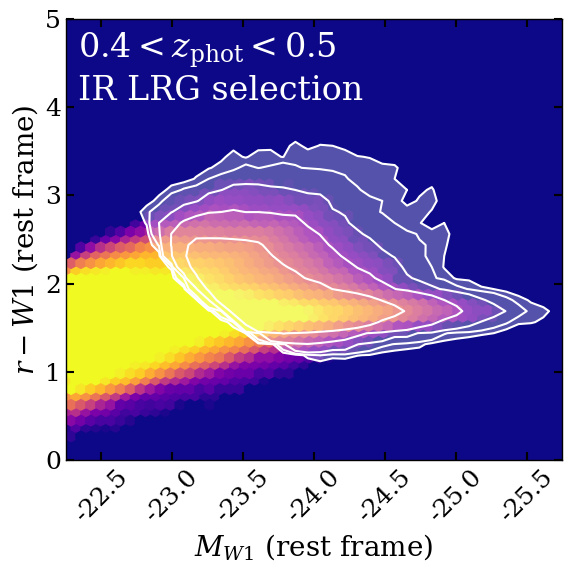

MW1	optical LRG selection


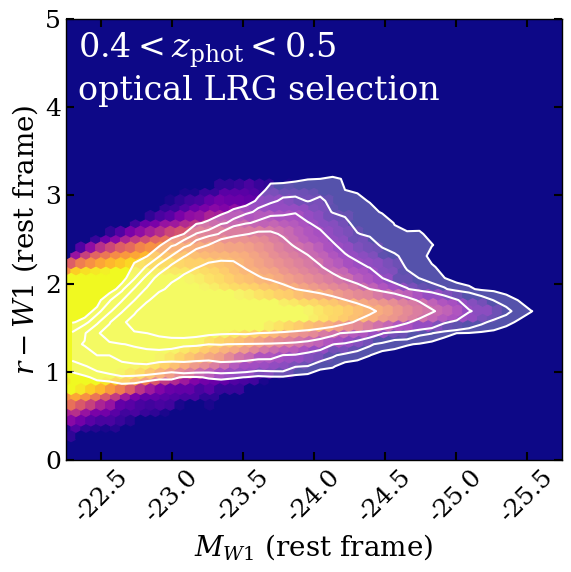

CPU times: user 46.3 s, sys: 3.62 s, total: 49.9 s
Wall time: 49.9 s


In [23]:
%%time

lrg_contours = True
for band in ("z", "W1"):
    for lrg_select in ("IR", "optical"):
        print(f"M{band}\t{lrg_select} LRG selection")
        # if band=="r":
        #     xlim_rest   = (-20.8,-23.3)
        #     xticks_rest = np.arange(-21,-23.3,-0.5)
        #     ylim        = (0.45,2.5)
        #     abs_mag_cut = Mr < Mr_lim
        #     mag_idx     = 1
        #     lrg_levels  = np.logspace(-1,1.5,8)
        #     l0 = "$M_r$ "
        if band=="z":
            xlim_rest   = (-21.6,-25.25)
            xticks_rest = np.arange(-22,-25.25,-0.5)
            ylim        = (0.25,1.6)
            abs_mag_cut = Mz < Mz_lim
            mag_idx     = 2
            lrg_levels  = np.logspace(-1,1.5,8)
            l0 = "$M_z$ "
        elif band=="W1":
            xlim_rest   = (-22.25,-25.75)
            xticks_rest = np.arange(-22.5,-25.75,-0.5)
            ylim        = (0,5)
            abs_mag_cut = MW1 < MW1_lim
            mag_idx     = 3
            lrg_levels  = np.logspace(-1.4,2,8)
            l0 = "$M_{W1}$ "
        else:
            raise Exception()

        if lrg_select=="optical":
            lrg_mask = desi_lrg_mask_optical(cat[abs_mag_cut])
        elif lrg_select=="IR":
            lrg_mask = desi_lrg_mask(cat[abs_mag_cut])
        else:
            raise Exception()

        fig, ax = plt.subplots(1, 1, figsize=(6,6))

        ax.tick_params(axis="both", which="major", labelsize=18)
        ax.set_ylim(ylim)

        ax.set_xlim(xlim_rest)
        ax.set_xticks(xticks_rest)
        ax.set_xticklabels(ax.get_xticks(), rotation=45)

        ax.set_xlabel(l0 + r"$({\rm rest\ frame})$", fontsize=20)
        #ax.set_ylabel(f"$g-{band}$ " + r"$({\rm rest\ frame})$", fontsize=20)
        ax.set_ylabel(f"$r-{band}$ " + r"$({\rm rest\ frame})$", fontsize=20)

        xx, yy = Mx[mag_idx][abs_mag_cut], (Mx[1]-Mx[mag_idx])[abs_mag_cut]

        hexbins   = np.logspace(1.8,4,50)
        hexkwargs = dict(bins=hexbins, xscale="linear", yscale="linear", gridsize=50, cmap="plasma")
        ax.hexbin(xx, yy, extent=(*ax.get_xlim(), *ax.get_ylim()), **hexkwargs)

        H, X, Y = np.histogram2d(xx[lrg_mask], yy[lrg_mask], bins=40, density=True, range=(ax.get_xlim()[::-1],ax.get_ylim()))
        x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
        y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

        txt = f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$" + "\n" + f"{lrg_select} LRG selection"
        
        if ("W1" in band):
            ax.text(*get_corners(ax, margin=0.025)["upper_left"], txt, ha="left", va="top", fontsize=24, color="white")
        else:
            ax.text(*get_corners(ax, margin=0.025)["lower_right"], txt, ha="right", va="bottom", fontsize=24, color="white")

        if lrg_contours:
            lrg_levels = np.quantile(H[H>0],np.arange((0.5 if ("W1" in band) else 0.4),1.01,0.1))
            ax.contour(x_cen, y_cen, H.T, levels=lrg_levels, colors="white", linewidths=1.5)
            ax.contourf(x_cen, y_cen, H.T, levels=lrg_levels, colors="white", alpha=0.3)
            figname = f"{BASEDIR}/figures/cmd_M{band}_r{band}_{cat_tag}_{lrg_select}-lrg.png"
        else:
            figname = f"{BASEDIR}/figures/cmd_M{band}_r{band}_{cat_tag}.png"

        plt.tight_layout()
        fig.savefig(figname, bbox_inches="tight", pad_inches=0.1)

        plt.show()


<a class="anchor" id="lrg_stats"></a>
# Color-magnitude space LRG fraction data for DESI optical & IR selection

[BACK TO TOP](#outline)


In [24]:
# lrg_mask_opt = desi_lrg_mask_optical( cat )
# lrg_mask_IR  = desi_lrg_mask( cat )



In [25]:
# fig, ax = plt.subplots(1, 1, figsize=(6,6))

# bins = np.arange(-25,-22.9,0.05)

# ax.hist(Mr[Mr < Mr_lim], bins=bins, color="gray", alpha=0.5)
# ax.hist(Mr[(Mr < Mr_lim) & lrg_mask_IR], bins=bins, alpha=0.5)
# ax.hist(Mr[(Mr < Mr_lim) & lrg_mask_opt], bins=bins, alpha=0.5)
# ax.set_xlim(-25, -22.8)

# plt.show()

In [26]:
# fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Mz_cut = Mz < Mz_lim
# MW_cut = MW1 < MW1_lim

# colors = get_colors(2)

# kwargs     = dict(color="gray", alpha=0.5, s=5)
# kwargs_IR  = dict(alpha=0.5, s=5, color=colors[1])
# kwargs_opt = dict(alpha=0.5, s=5, color=colors[0])

# ax = axes[0]
# ax.scatter(Mz[Mz_cut], r_z[Mz_cut], **kwargs)
# ax.scatter(Mz[Mz_cut & lrg_mask_IR], r_z[Mz_cut & lrg_mask_IR], **kwargs_IR)
# ax.scatter(Mz[Mz_cut & lrg_mask_opt], r_z[Mz_cut & lrg_mask_opt], **kwargs_opt)
# ax.set_xlim(-21,-24.6)
# ax.set_ylim(0.25,3)
# ax.set_xlabel("$M_z$", fontsize=20)
# ax.set_ylabel("$r-z$", fontsize=20)

# txt = f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$"
# ax.text(*get_corners(ax, margin=0.05)["upper_right"], txt, ha="right", va="top", fontsize=20)


# ax = axes[1]
# ax.scatter(MW1[MW_cut], r_W1[MW_cut], color="gray", alpha=0.5, s=5)
# ax.scatter(MW1[MW_cut & lrg_mask_IR], r_W1[MW_cut & lrg_mask_IR], **kwargs_IR)
# ax.scatter(MW1[MW_cut & lrg_mask_opt], r_W1[MW_cut & lrg_mask_opt], **kwargs_opt)
# ax.set_xlim(-22.5,-26.2)
# ax.set_ylim(2.25,5.75)
# ax.set_xlabel("$M_{W1}$", fontsize=20)
# ax.set_ylabel("$r-W1$", fontsize=20)

# for ax in axes:
#     ax.tick_params(axis="both", which="major", labelsize=20)#, direction="in", color="white", width=2)

# plt.tight_layout()

# figname = f"{BASEDIR}/figures/outlier-LRG-test_{cat_tag}.png"
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1)

# plt.show()


In [27]:
def f(lrg_mask, save=True, plot=False):
    if (save and plot) | (not save and not plot):
        raise Exception()
    xx, yy = Mx[mag_idx][abs_mag_cut][lrg_mask], (Mx[1]-Mx[mag_idx])[abs_mag_cut][lrg_mask]

    xbw = 0.05
    ybw = 0.05

    xmin, xmax = np.floor(np.min(xx)/xbw)*xbw, np.ceil(np.max(xx)/xbw)*xbw
    xbins = np.arange(xmin, xmax+xbw, xbw)

    ymin, ymax = np.floor(np.min(yy)/ybw)*ybw, np.ceil(np.max(yy)/ybw)*ybw 
    ybins = np.arange(ymin, ymax+ybw, ybw)

    H_lrg, X, Y = np.histogram2d(xx, yy, bins=(xbins,ybins))
    x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
    y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

    xx, yy = Mx[mag_idx][abs_mag_cut], (Mx[1]-Mx[mag_idx])[abs_mag_cut]

    H_full,_,_ = np.histogram2d(xx, yy, bins=(xbins,ybins))

    if plot and not save:
        return (x_cen, y_cen, (H_lrg/H_full).T) # return stats formatted for plotting
    elif save and not plot:
        return (xbins, ybins, H_lrg.T, H_full.T) # return stats formatted for saving
    else:
        raise Exception()


z


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
/tmp/ipykernel_12170/1335409224.py:24: RuntimeWarning: invalid value encountered in true_divide
  return (x_cen, y_cen, (H_lrg/H_full).T) # return stats formatted for plotting


/global/cscratch1/sd/aberti/SHAM/figures/lrgfrac_Mz_rz_z0p40-0p50_south.png


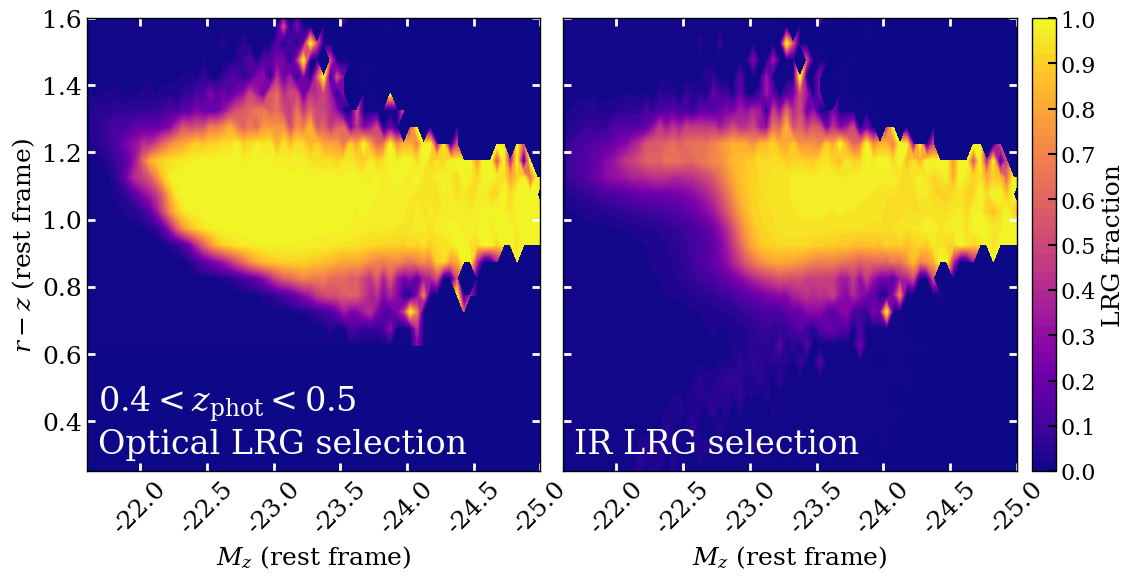

W1
/global/cscratch1/sd/aberti/SHAM/figures/lrgfrac_MW1_rW1_z0p40-0p50_south.png


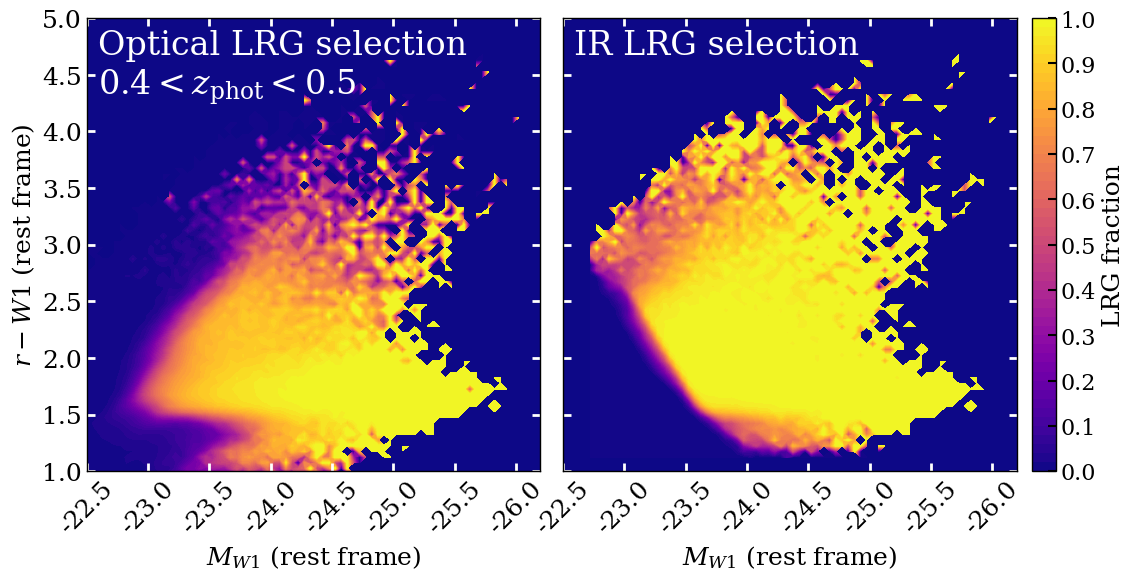

In [28]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap("plasma")

for band in ("z","W1"):
    print(band)
    if band=="r":
        xlim        = (-21,-24.6)
        xticks      = np.arange(-21,-25,-0.5)
        ylim        = (0.25,3)
        abs_mag_cut = Mr < Mr_lim
        mag_idx     = 1
        l0          = "$M_r$ "
    elif band=="z":
        xlim        = (-21.6,-25)
        xticks      = np.arange(-22,-25.1,-0.5)
        ylim        = (0.25,1.6)
        abs_mag_cut = Mz < Mz_lim
        mag_idx     = 2
        l0          = "$M_z$ "
    elif band=="W1":
        xlim        = (-22.5,-26.2)
        xticks      = np.arange(-22.5,-26.1,-0.5)
        ylim        = (1,5)
        abs_mag_cut = MW1 < MW1_lim
        mag_idx     = 3
        l0          = "$M_{W1}$ "
    else:
        raise Exception()

    opt = f(desi_lrg_mask_optical( cat[abs_mag_cut] ))
    np.save(f"{BASEDIR}/stats/lrgfrac_optical-select_{band}-band_{cat_tag}.npy", opt)

    IR  = f(desi_lrg_mask( cat[abs_mag_cut] ))
    np.save(f"{BASEDIR}/stats/lrgfrac_IR-select_{band}-band_{cat_tag}.npy", IR)

    opt = f(desi_lrg_mask_optical( cat[abs_mag_cut] ), save=False, plot=True)
    IR  = f(desi_lrg_mask( cat[abs_mag_cut] ), save=False, plot=True)

    fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

    for ax in axes:
        ax.tick_params(axis="both", which="major", labelsize=18, direction="in", color="white", width=2)
        ax.set_xlim(xlim)
        ax.set_xticks(xticks)
        ax.set_ylim(ylim)
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_facecolor(cmap(0.0))
        ax.set_xlabel(l0 + r"$({\rm rest\ frame})$", fontsize=18)

    levels = np.arange(0,1.01,0.02)

    ### OPTICAL SELECTION ###
    ax = axes[0]
    ax.set_ylabel(f"$r-{band}$ " + r"$({\rm rest\ frame})$", fontsize=18)

    ax.contourf(*opt, cmap="plasma", levels=levels)
    # ax.set_title("Optical LRG selection", fontsize=18)

    if ("W1" in band):# & (zmin==0.6):
        txt = "Optical LRG selection\n" + f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$"
        ax.text(*get_corners(ax, margin=0.025)["upper_left"], txt, ha="left", va="top", fontsize=24, color="white")
    else:
        txt = f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$" + "\nOptical LRG selection"
        ax.text(*get_corners(ax, margin=0.025)["lower_left"], txt, ha="left", va="bottom", fontsize=24, color="white")
    
    ### IR SELECTION ###
    ax = axes[1]
    cbar = ax.contourf(*IR, cmap="plasma", levels=levels)
    # ax.set_title("IR LRG selection", fontsize=18)

    txt = "IR LRG selection"
    if ("W1" in band):# & (zmin==0.6):
        ax.text(*get_corners(ax, margin=0.025)["upper_left"], txt, ha="left", va="top", fontsize=24, color="white")
    else:
        ax.text(*get_corners(ax, margin=0.025)["lower_left"], txt, ha="left", va="bottom", fontsize=24, color="white")
        
    cax = plt.axes([0.9125,0.125,0.02,0.755])
    fig.colorbar(cbar, cax=cax).set_ticks(levels[0::5])

    cax.set_ylabel("LRG fraction", fontsize=18)
    cax.tick_params(labelsize=16)

    figname = f"{BASEDIR}/figures/lrgfrac_M{band}_r{band}_{cat_tag}.png"
    print(figname)

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    fig.savefig(figname, bbox_inches="tight", pad_inches=0.1)

    plt.show()


<a class="anchor" id="color_dist"></a>
# Galaxy color distributions at fixed absolute magnitude

[BACK TO TOP](#outline)

### Specify band (r / z / W1)

z


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


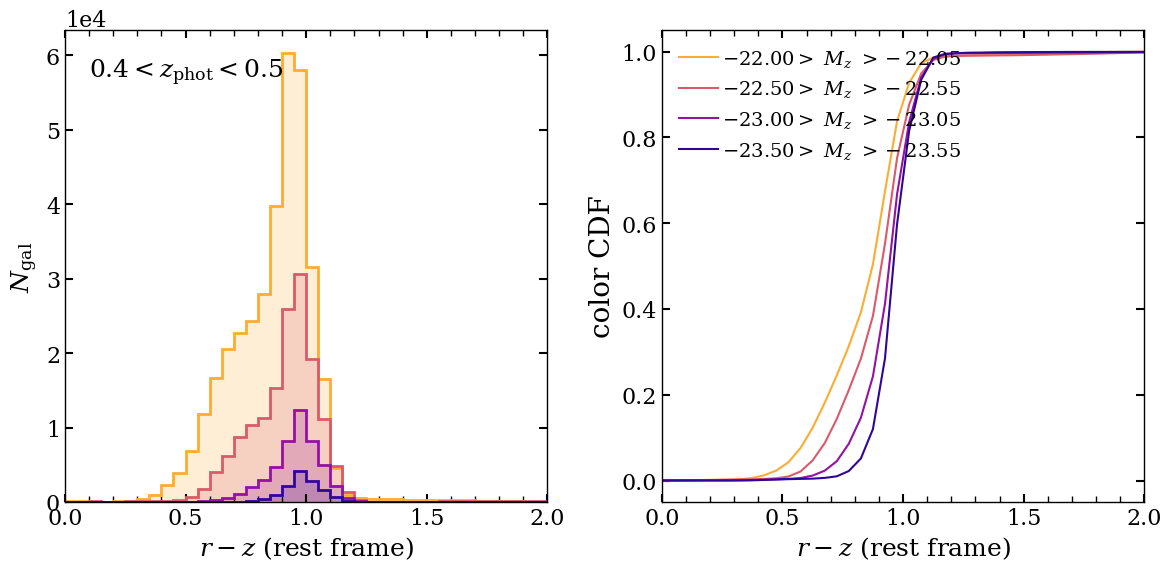

/global/cscratch1/sd/aberti/SHAM/color_cdfs/cdf_r-z_z0p40-0p50_south_zmaglim20p7_Mzlimn21p6.npy
/global/cscratch1/sd/aberti/SHAM/figures/cdf_r-z_z0p40-0p50_south_zmaglim20p7_Mzlimn21p6.png
W1


/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


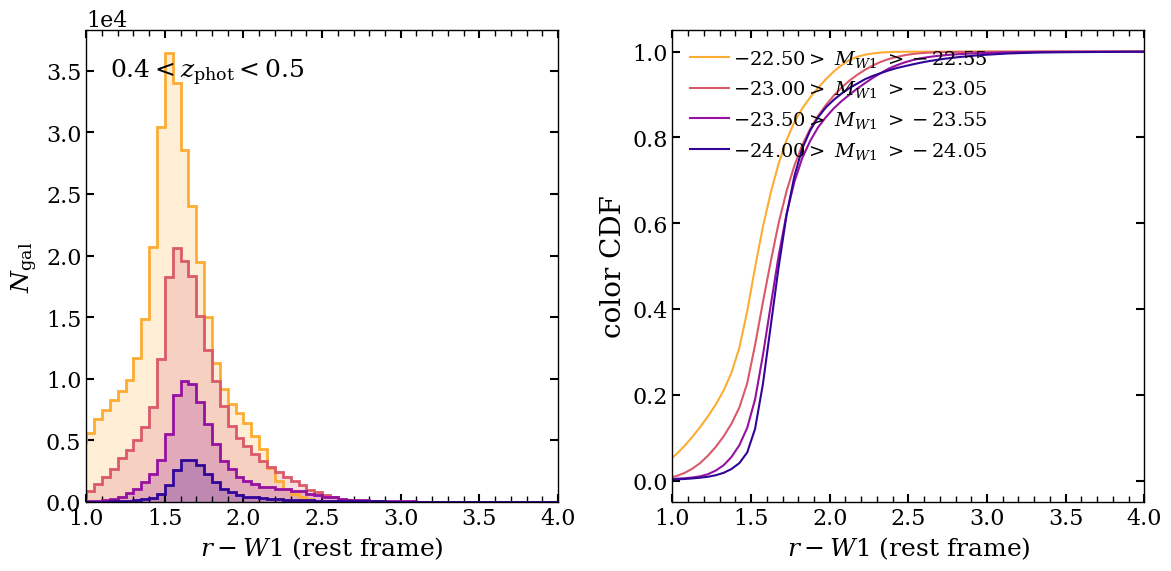

/global/cscratch1/sd/aberti/SHAM/color_cdfs/cdf_r-W1_z0p40-0p50_south_zmaglim20p7_MW1limn22p25.npy
/global/cscratch1/sd/aberti/SHAM/figures/cdf_r-W1_z0p40-0p50_south_zmaglim20p7_MW1limn22p25.png


In [29]:
plot_colors = get_colors(4)[::-1]

for band in ("z","W1"):
    print(band)
    color_key = f"r-{band}"
    mag_key   = f"M{band}"

    rcParams["font.family"] = "serif"
    rcParams["mathtext.fontset"] = "dejavuserif"

    if band=="W1":
        abs_mag_lim = MW1_lim
        abs_mag_tag = get_MW1_tag(MW1_lim)
        maglab      = r"$\ M_{W1}\ $"
    elif band=="z":
        abs_mag_lim = Mz_lim
        abs_mag_tag = get_Mz_tag(Mz_lim)
        maglab      = r"$\ M_z\ $"
    elif band=="r":
        abs_mag_lim = Mr_lim
        abs_mag_tag = get_Mr_tag(Mr_lim)
        maglab      = r"$\ M_r\ $"
    else:
        raise Exception()    

    if mag_key[1:] not in color_key:
        raise Exception()

    color_dict  = {"r-z":r_z, "r-W1":r_W1} #"g-r":g_r, "g-W1":g_W1}
    color_range = {"r-z":(0,2), "r-W1":(1,4)}
    color       = color_dict[color_key]

    mag_dict = {"Mg":Mg, "Mr":Mr, "Mz":Mz, "MW1":MW1}
    mag      = mag_dict[mag_key]

    mag_bins   = np.concatenate([ [-10.], np.arange(-20.,-25.1,-0.05), [-28.] ])
    color_bins = np.arange(-6,6.25,0.05)
    color_cens = [np.mean(color_bins[i:i+2]) for i in range(len(color_bins)-1)]

    fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True)

    color_cdf_mag_binned = {}
    color_cdf_mag_binned["color_cens"] = color_cens

    c  = 0
    cc = 0
    for i in range(len(mag_bins)-1):
        mag_min, mag_max = mag_bins[i:i+2]

        mag_bin_label = f"n{np.abs(mag_min):.2f}-n{np.abs(mag_max):.2f}"
        mag_bin_label = mag_bin_label.replace(".","p")

        mag_mask = (mag < mag_min) & (mag >= mag_max) & (mag <= abs_mag_lim)
        N = len(color[mag_mask])

        H,_ = np.histogram(color[mag_mask], bins=color_bins, density=True)
        cdf = np.cumsum(H)/np.cumsum(H)[-1]
        color_cdf_mag_binned[mag_bin_label] = cdf

        if i==0:
            label = maglab + f"$ > {mag_max}$"
        elif i==np.max(range(len(mag_bins)-1)):
            label = maglab + f"$ < {mag_min}$"
        else:
            label = f"${mag_min:.2f} > $" + maglab + f"$ > {mag_max:.2f}$"
        if (i%10==1) & (N > 1e4) & (c < 4):        
            axes[1].plot(color_cens, cdf, label=label, color=plot_colors[c])
            c += 1

        if (i%10==1) & (N > 1e4) & (cc < 4):
            axes[0].hist(color[mag_mask], bins=color_bins, alpha=0.2, color=plot_colors[cc])
            axes[0].hist(color[mag_mask], bins=color_bins, histtype="step", lw=2, label=label, color=plot_colors[cc])
            cc += 1
            axes[0].set_xlim( color_range[color_key] )

    axes[1].legend(frameon=False, fontsize=14, loc=2, handletextpad=0.2)# ,loc=(0.025,0.55))
    axes[1].set_ylabel(r"color CDF", fontsize=20)

    axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    xmin, xmax = axes[0].get_xlim()
    ymin, ymax = axes[0].get_ylim()
    xt = xmin + 0.05*(xmax-xmin)
    yt = ymax - 0.10*(ymax-ymin)

    axes[0].text(xt, yt,rf"${zmin}$" + r"$<z_{\rm phot}<$" + rf"${zmax}$", fontsize=18)
    axes[0].set_ylabel(r"$N_{\rm gal}$", fontsize=18)

    for ax in axes:
        ax.tick_params(axis="both", which="major", labelsize=16)
        ax.set_xlabel(f"${color_key}$ " + r"$({\rm rest\ frame})$", fontsize=18)
    plt.tight_layout() 
    plt.show()

    cat_tag  = get_cat_tag(d, zrange)
    zmag_tag = get_zmag_tag(zmag_lim)

    tabname = f"{BASEDIR}/color_cdfs/cdf_{color_key}_{cat_tag}_{zmag_tag}_{abs_mag_tag}.npy"
    print(tabname)

    figname = f"{BASEDIR}/figures/cdf_{color_key}_{cat_tag}_{zmag_tag}_{abs_mag_tag}.png"
    print(figname)

    np.save(tabname, Table(color_cdf_mag_binned))
    fig.savefig(figname, bbox_inches="tight", pad_inches=0.1)


<a class="anchor" id="sky_cover"></a>
# Data and random sky coverage (masked/unmasked) with jackknife patches

[BACK TO TOP](#outline)


In [30]:
# %%time

# d    = "north"
# save = False

# print(f"Loading {d.upper()} randoms...")
# if d=="north":
#     rand = np.load(f"{DATADIR}/random/{d}_full.npy")
# else:
#     rand = vstack([ Table(np.load(f"{DATADIR}/random/{d}_full_{i}of2.npy")) for i in (1,2) ])    
    
# rand_geo_mask = ~(rand["BITMASK"] | rand[f"COORDMASK_{d.upper()}"])

# print("{:.3f}\tData maskbits".format( len(rand[~rand["BITMASK"]]) / len(rand) ))
# print("{:.3f}\tRA/Dec cuts to data area".format( len(rand[~rand[f"COORDMASK_{d.upper()}"]]) / len(rand) ))
# print("{:.3f}\tCombined".format( len(rand[rand_geo_mask]) / len(rand) ))

# RA  = rand["RA"]
# Dec = rand["DEC"]

# # print("{:.3f}\tData maskbits".format( len(RA[rand[d.upper()] & ~rand["BITMASK"]]) / len(RA[rand[d.upper()]])) )
# # print("{:.3f}\tRA/Dec cuts to data area".format( len(RA[rand[d.upper()] & ~rand[f"COORDMASK_{d.upper()}"]]) / len(RA[rand[d.upper()]])) )
# # print("{:.3f}\tCombined".format( len(RA[rand_geo_mask]) / len(RA[rand[d.upper()]])) )

# cm1 = plt.get_cmap("tab20b")
# cm2 = plt.get_cmap("tab20c")

# if d=="north":
#     ds = 20
#     xlim, ylim = (88,301), (30,85)
#     xticks, yticks = np.arange(90,305,5), np.arange(30,90,5)
# elif d=="south":
#     ds = 100
#     xlim, ylim = (0,360), (-70,36)
#     xticks, yticks = np.arange(0,370,10), np.arange(-70,40,5)

# fig, ax = plt.subplots(1,1,figsize=(30,10))
# ax.set_prop_cycle(color=np.concatenate([cm1.colors,cm2.colors]))
# ax.scatter(RA[::ds], Dec[::ds], s=1, color="black")
# counts = {}
# for p in np.unique(rand["PATCH"]):
#     patch_mask = rand["PATCH"]==p
#     ax.scatter(RA[rand_geo_mask & patch_mask][::ds], Dec[rand_geo_mask & patch_mask][::ds], s=1, alpha=0.5)
#     #ax.scatter(RA[rand_geo_mask][::ds], Dec[rand_geo_mask][::ds], s=1, color="gray")
#     c = len(RA[rand_geo_mask & patch_mask])
#     if c > 0:
#         counts[p] = c
# #         x0 = np.median(RA[rand_geo_mask & patch_mask])
# #         y0 = np.median(Dec[rand_geo_mask & patch_mask])
# #         ax.text(x0, y0, p, ha="center", va="center", fontsize=16)
            
# ax.grid(ls=":")
# ax.set_xlim(*xlim)
# ax.set_ylim(*ylim)
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)

# ax.set_xlabel("RA", fontsize=16)
# ax.set_ylabel("Dec", fontsize=16)

# if save:
#     plt.savefig(f"{BASEDIR}/figures/masked_random_{d}.png", bbox_inches="tight", pad_inches=0.1, dpi=200)
    
# plt.show()
    

<a class="anchor" id="doe"></a>
# DOE renewal proposal figures

[BACK TO TOP](#outline)


In [31]:
# def extra_masks(cat, d=None, zrange=None, quiet=False, zkcorr=None, zphot_tag="Z_PHOT_MEAN", mask_name=None):
#     assert(mask_name != None)
#     snaps = {}
#     for i in np.arange(0,10,1): snaps[round(0.1*i,1)] = zsnaps[int(i)]
    
#     zmin, zmax = zrange
#     assert( (zmax > zmin) & (zmin in snaps.keys()) )

#     if (zkcorr=="zsnap") | (zkcorr==None) : zkcorr = snaps[zmin]
#     if not quiet : print(f"K-correction redshift set to {zkcorr}")

#     mg  = 2.5*( 9 - np.log10(cat["FLUX_G"]/cat["MW_TRANSMISSION_G"]) )
#     mr  = 2.5*( 9 - np.log10(cat["FLUX_R"]/cat["MW_TRANSMISSION_R"]) )
#     mz  = 2.5*( 9 - np.log10(cat["FLUX_Z"]/cat["MW_TRANSMISSION_Z"]) )
#     mW1 = 2.5*( 9 - np.log10(cat["FLUX_W1"]/cat["MW_TRANSMISSION_W1"]) )

#     mx = np.array( [mg, mr, mz, mW1] )

#     Kx_all = load_kcorr(d=d, zrange=zrange, zkcorr=zkcorr, quiet=quiet)
#     Kx     = np.array( [k for k in Kx_all] )
#     Kg, Kr, Kz, KW1 = Kx[:-1]

#     Mx = mx - cosmo.distmod( cat[zphot_tag] ).value - Kx[:-1]

#     g_r = (mg - Kg) - (mr - Kr)
#     Mr  = Mx[1]
    
#     g_W1 = (mg - Kg) - (mW1 - KW1)
#     MW1  = Mx[3]
    
#     if mask_name=="red_seq_Mr_vs_g-r_z0p4-0p5_box1":
#         mask = (-22.4 < Mr) & (Mr < -19.8) & (1.5 < g_r) & (g_r < 2.0)
#     elif mask_name=="red_seq_Mr_vs_g-r_z0p4-0p5_line1":
#         mask = g_r > -0.148*Mr - 1.63575
        
#     elif mask_name=="red_seq_MW1_vs_g-W1_z0p4-0p5_box1":
#         mask = (-24 < MW1) & (MW1 < -21) & (2.8 < g_W1) & (g_W1 < 4.0)
#     elif mask_name=="red_seq_MW1_vs_g-W1_z0p4-0p5_line1":
#         mask = g_W1 > -0.273*MW1 - 3.113095
    
#     else:
#         raise Exception("Invalid extra mask name!")

#     return mask


In [32]:
# %%time

# IR_mask      = extra_masks(cat, d=d, zrange=zrange, mask_name="red_seq_MW1_vs_g-W1_z0p4-0p5_line1")
# optical_mask = extra_masks(cat, d=d, zrange=zrange, mask_name="red_seq_Mr_vs_g-r_z0p4-0p5_line1")

# # optical_mask = g_r > -0.148*Mr - 1.63575
# # IR_mask      = g_W1 > -0.273*MW1 - 3.113095

# N_IR  = len(cat[all_mask & IR_mask])
# N_opt = len(cat[all_mask & optical_mask])
# N_all = len(cat[all_mask])

# # print(N_all, N_opt, N_IR)

# # print("\n{:.5f}\t{:.5f}".format(N_opt/N_all, N_IR/N_all))


In [33]:
# def mb(p0,p1):
#     (x0,y0) = p0
#     (x1,y1) = p1
#     m = (y1-y0)/(x1-x0)
#     b = y0 - m*x0
#     return m, b

# # m_IR, b_IR = mb((-20.7,2.55),(-24,3.45))

# # m_opt, b_opt = mb((-19.8,1.3),(-22.5,1.7))

# m_opt, b_opt = -0.148, -1.63575
# m_IR, b_IR   = -0.273, -3.113095


# # print("{:.3f}\t{:.3f}".format(m_IR, b_IR))
# # print(len( g_W1[(g_W1 > m_IR*MW1 + b_IR)] ))

# # print("{:.3f}\t{:.3f}".format(m_opt, b_opt))
# # print(len( g_r[(g_r > m_opt*Mr + b_opt)] ))


In [34]:
# %%time

# from matplotlib import rcParams
# rcParams["font.family"] = "serif"
# rcParams["mathtext.fontset"] = "dejavuserif"

# fig, axes = plt.subplots(1, 2, figsize=(16,8))

# Mr_bins  = np.arange(-19.7, -23.56, -0.05)
# gr_bins  = np.arange(0.65, 2.11, 0.05)

# MW1_bins = np.arange(-20.5, -25.26, -0.05)
# gW1_bins  = np.arange(0.95, 4.56, 0.05)

# ax = axes[0]
# H, xx, yy = np.histogram2d(Mr, g_r, bins=(Mr_bins[::-1], gr_bins), range=((Mr_bins[-1],Mr_bins[0]),(gr_bins[0],gr_bins[-1])), normed=None, weights=None, density=None)
# X = [np.mean(xx[i:i+2]) for i in range(len(xx)-1)]
# Y = [np.mean(yy[i:i+2]) for i in range(len(yy)-1)]

# levels = 10

# ax.contourf(X, Y, H.T, levels, cmap="binary")
# ax.contour(X, Y, H.T, levels, colors="white", linewidths=2)
# ax.set_xlim(-19.75, -23)
# ax.set_xticks(np.arange(-20, -23.01, -0.5))
# ax.set_ylim(0.7, 2.05)

# xmin, xmax = ax.get_xlim()
# ymin, ymax = ax.get_ylim()
# xt = xmax - 0.05*(xmax-xmin)
# yt = ymin + 0.05*(ymax-ymin)
# ax.text(xt, yt, r"$0.4<z_{\rm phot} < 0.5$", fontsize=22, ha="right", va="bottom")

# # ax.plot(Mr_bins, m_opt*Mr_bins + b_opt, color="red", lw=2)
# # line_mask = extra_masks(cat, d=d, zrange=zrange, mask_name="red_seq_Mr_vs_g-r_z0p4-0p5_line1")[all_mask]
# # ax.fill_between(Mr_bins, m_opt*Mr_bins + b_opt, m_opt*Mr_bins + b_opt+100, color="red", alpha=0.2)

# # ax.scatter(Mr[lrg_mask][::5], g_r[lrg_mask][::5], s=10, alpha=0.2)
# H, xx, yy = np.histogram2d(Mr[lrg_mask], g_r[lrg_mask], bins=(Mr_bins[::-1], gr_bins), range=((Mr_bins[-1],Mr_bins[0]),(gr_bins[0],gr_bins[-1])), normed=None, weights=None, density=None)
# X = [np.mean(xx[i:i+2]) for i in range(len(xx)-1)]
# Y = [np.mean(yy[i:i+2]) for i in range(len(yy)-1)]
# ax.contourf(X, Y, H.T, [125,250,500,1000,2000,4000,8000], colors="red", alpha=0.1)
# ax.contour(X, Y, H.T, [125,250,500,1000,2000,4000,8000], colors="red", linewidths=1.5)


# ax = axes[1]
# H, xx, yy = np.histogram2d(MW1, g_W1, bins=(MW1_bins[::-1], gW1_bins), range=((MW1_bins[-1],MW1_bins[0]),(gW1_bins[0],gW1_bins[-1])), normed=None, weights=None, density=None)
# X = [np.mean(xx[i:i+2]) for i in range(len(xx)-1)]
# Y = [np.mean(yy[i:i+2]) for i in range(len(yy)-1)]

# ax.contourf(X, Y, H.T, levels, cmap="binary")
# ax.contour(X, Y, H.T, levels, colors="white", linewidths=2)
# ax.set_xlim(-20.7, -25.1)
# ax.set_xticks(np.arange(-21.0, -25.01, -1))
# #ax.set_ylim(1.15, 4.05)
# ax.set_ylim(1.15, 4.5)
# ax.set_yticks(np.arange(1.5, 4.51, 0.5))

# # ax.plot(MW1_bins, m_IR*MW1_bins + b_IR, color="magenta", ls="--", lw=2)
# # line_mask = extra_masks(cat, d=d, zrange=zrange, mask_name="red_seq_MW1_vs_g-W1_z0p4-0p5_line1")[all_mask]
# # ax.fill_between(MW1_bins, m_IR*MW1_bins + b_IR, m_IR*MW1_bins + b_IR+100, color="magenta", alpha=0.1)

# # ax.scatter(MW1[lrg_mask][::5], g_W1[lrg_mask][::5], s=10, alpha=0.2)
# H, xx, yy = np.histogram2d(MW1[lrg_mask], g_W1[lrg_mask], bins=(MW1_bins[::-1], gW1_bins), range=((MW1_bins[-1],MW1_bins[0]),(gW1_bins[0],gW1_bins[-1])), normed=None, weights=None, density=None)
# X = [np.mean(xx[i:i+2]) for i in range(len(xx)-1)]
# Y = [np.mean(yy[i:i+2]) for i in range(len(yy)-1)]
# ax.contourf(X, Y, H.T, [10,50,125,250,500,1000,3000], colors="magenta", alpha=0.1)
# ax.contour(X, Y, H.T, [10,50,125,250,500,1000,3000], colors="magenta", linewidths=1.5)

# for ax in axes: ax.tick_params(axis="both", which="major", labelsize=16)

# axes[0].set_xlabel(r"$M_r$", fontsize=20)
# axes[0].set_ylabel(r"$g-r$", fontsize=20)
# axes[1].set_xlabel(r"$M_{W1}$", fontsize=20)
# axes[1].set_ylabel(r"$g-W1$", fontsize=20)

# plt.subplots_adjust(wspace=0.175)
# #plt.savefig(f"{BASEDIR}/figures/LRG_optical_selection_cmd.png", bbox_inches="tight", pad_inches=0.1)

# plt.show()


In [35]:
# #for (MW1_lim, Mr_lim) in ((-22.5, -21.0), (-22.0, -20.5), (-21.5, -20.0)):
# for (MW1_lim, Mr_lim) in ((-22.25,-20.80),(-22.25,-20.80))[:1]:
#     fig, axes = plt.subplots(2, 2, figsize=(12,12))
#     plt.rcParams["figure.dpi"] = 100
#     plt.rcParams["savefig.dpi"] = 200

#     dens = False
#     DS   = 10

#     # MW1_lim = -22.25
#     # Mr_lim  = -20.75

#     MW1_cut = MW1 < MW1_lim
#     Mr_cut  = Mr < Mr_lim
#     MW1_cut_kwargs = dict(lw=2, histtype="step", color="darkviolet")
#     Mr_cut_kwargs  = dict(lw=2, histtype="step", color="black")


#     for ax in axes[0]:
#         ax.set_xlim(-25,-20.5)
#         #ax.set_ylim(0,1.6)
#         ax.set_xticks(np.arange(-25,-20.5,0.5))
#         ax.set_xticklabels(ax.get_xticks(),rotation=45)
#         ax.set_xlabel(r"$M_{W1}$", fontsize=20)

#     for ax in axes[1]:
#         ax.set_xlim(-23.25,-19.75)
#         #ax.set_ylim(0,1.4)
#         ax.set_xticks(np.arange(-23,-19.5,0.5))
#         ax.set_xticklabels(ax.get_xticks(),rotation=45)
#         ax.set_xlabel(r"$M_r$", fontsize=20)


#     kwargs = dict(fontsize=16, ha="right", va="top")
#     loc = "upper_right"

#     ax = axes[0][0]
#     ax.hist(MW1[::DS], bins=MW1_bins[::-1], density=dens, alpha=0.5, color="gray")
#     ax.hist(MW1[lrg_mask_optical], bins=MW1_bins[::-1], density=dens, alpha=0.5, color="red")

#     ax.hist(MW1[::DS][MW1_cut[::DS]], bins=MW1_bins[::-1], density=dens, **MW1_cut_kwargs)
#     ax.hist(MW1[Mr_cut & lrg_mask_optical], bins=MW1_bins[::-1], **Mr_cut_kwargs)

#     ymax = ax.get_ylim()[1]
#     ax.set_ylim(0,1.1*ymax)
#     ax.text(*get_corners(ax, margin=0.05)["upper_left"], "Optical selection", ha="left", va="top", fontsize=16)
#     pct_lrg_loss = round(1 - len(MW1[Mr_cut & lrg_mask_optical]) / len(MW1[lrg_mask_optical]),4)
#     label = f"$Mr < {Mr_lim}$" + f"\n{100*pct_lrg_loss:.2f}% LRG loss"
#     ax.text(*get_corners(ax, margin=0.05)[loc], label, **kwargs)

#     ax = axes[0][1]
#     ax.hist(MW1[::DS], bins=MW1_bins[::-1], density=dens, alpha=0.5, color="gray")
#     ax.hist(MW1[lrg_mask], bins=MW1_bins[::-1], density=dens, alpha=0.5, color="red")

#     ax.hist(MW1[::DS][MW1_cut[::DS]], bins=MW1_bins[::-1], density=dens, **MW1_cut_kwargs)
#     ax.hist(MW1[Mr_cut & lrg_mask], bins=MW1_bins[::-1], density=dens, **Mr_cut_kwargs)

#     ymax = ax.get_ylim()[1]
#     ax.set_ylim(0,1.1*ymax)
#     ax.text(*get_corners(ax, margin=0.05)["upper_left"], "IR selection", ha="left", va="top", fontsize=16)
#     pct_lrg_loss = round(1 - len(MW1[Mr_cut & lrg_mask]) / len(MW1[lrg_mask]),4)
#     label = f"$Mr < {Mr_lim}$" + f"\n{100*pct_lrg_loss:.2f}% LRG loss"
#     ax.text(*get_corners(ax, margin=0.05)[loc], label, **kwargs)

#     ax = axes[1][0]
#     ax.hist(Mr[::DS], bins=Mr_bins[::-1], density=dens, alpha=0.5, color="gray")
#     ax.hist(Mr[lrg_mask_optical], bins=Mr_bins[::-1], density=dens, alpha=0.5, color="red")

#     ax.hist(Mr[::DS][Mr_cut[::DS]], bins=Mr_bins[::-1], density=dens, **Mr_cut_kwargs)
#     ax.hist(Mr[MW1_cut & lrg_mask_optical], bins=Mr_bins[::-1], density=dens, **MW1_cut_kwargs)

#     ymax = ax.get_ylim()[1]
#     ax.set_ylim(0,1.1*ymax)
#     ax.text(*get_corners(ax, margin=0.05)["upper_left"], "Optical selection", ha="left", va="top", fontsize=16)
#     pct_lrg_loss = round(1-len(Mr[MW1_cut & lrg_mask_optical])/len(Mr[lrg_mask_optical]),4)
#     label = f"$MW1 < {MW1_lim}$" + f"\n{100*pct_lrg_loss:.2f}% LRG loss"
#     ax.text(*get_corners(ax, margin=0.05)[loc], label, **kwargs)

#     ax = axes[1][1]
#     ax.hist(Mr[::DS], bins=Mr_bins[::-1], density=dens, alpha=0.5, color="gray", label="all galaxies")
#     ax.hist(Mr[lrg_mask], bins=Mr_bins[::-1], density=dens, alpha=0.5, color="red", label="LRGs")
#     ax.legend(loc=(0.025,0.6), fontsize=16, frameon=False, handletextpad=0.2)

#     ax.hist(Mr[::DS][Mr_cut[::DS]], bins=Mr_bins[::-1], density=dens, **Mr_cut_kwargs)
#     ax.hist(Mr[MW1_cut & lrg_mask], bins=Mr_bins[::-1], density=dens, **MW1_cut_kwargs)

#     ymax = ax.get_ylim()[1]
#     ax.set_ylim(0,1.15*ymax)
#     ax.text(*get_corners(ax, margin=0.05)["upper_left"], "IR selection", ha="left", va="top", fontsize=16)
#     pct_lrg_loss = round(1-len(Mr[MW1_cut & lrg_mask]) / len(Mr[lrg_mask]),4)
#     label = f"$MW1 < {MW1_lim}$" + f"\n{100*pct_lrg_loss:.2f}% LRG loss"
#     ax.text(*get_corners(ax, margin=0.05)[loc], label, **kwargs)

#     for ax in np.concatenate(axes):
#         ax.tick_params(axis="both", which="major", labelsize=16)
#         ax.set_yticklabels([])

#     plt.subplots_adjust(wspace=0.025, hspace=0.3)

#     mag_tag = "Mr-" + str(np.abs(Mr_lim)).replace(".","p") + "_MW1-" + str(np.abs(MW1_lim)).replace(".","p")
#     ztag = f"{zmin}-{zmax}"
#     ztag = ztag.replace(".","p")

#     #plt.savefig(f"{BASEDIR}/figures/parent_sample_mag_cut_pct_lrg_loss_{mag_tag}_z{ztag}_{d}.png", bbox_inches="tight", pad_inches=0.1)

#     plt.show()


In [36]:
# for (MW1_lim, Mr_lim) in ((-22.5, -21.0), (-22.0, -20.5), (-21.5, -20.0))[1:-1]:
#     fig, axes = plt.subplots(1, 2, figsize=(12,6))
#     plt.rcParams["figure.dpi"] = 100
#     plt.rcParams["savefig.dpi"] = 200

#     dens = False
#     DS   = 10

#     # MW1_lim = -22.25
#     # Mr_lim  = -20.75

#     MW1_cut = MW1 < MW1_lim
#     Mr_cut  = Mr < Mr_lim
#     MW1_cut_kwargs = dict(lw=2, histtype="step", color="darkviolet")
#     Mr_cut_kwargs  = dict(lw=2, histtype="step", color="black")


#     ax = axes[0]
#     ax.set_xlim(-25,-20.5)
#     #ax.set_ylim(0,1.6)
#     ax.set_xticks(np.arange(-25,-20.5,0.5))
#     ax.set_xticklabels(ax.get_xticks(),rotation=45)
#     ax.set_xlabel(r"$M_{W1}$", fontsize=20)

#     ax = axes[1]
#     ax.set_xlim(-23.25,-19.75)
#     #ax.set_ylim(0,1.4)
#     ax.set_xticks(np.arange(-23,-19.5,0.5))
#     ax.set_xticklabels(ax.get_xticks(),rotation=45)
#     ax.set_xlabel(r"$M_r$", fontsize=20)

#     kwargs = dict(fontsize=16, ha="left", va="top")
#     loc = "upper_left"

#     ax = axes[0]
#     ax.hist(MW1, bins=MW1_bins[::-1], density=dens, alpha=0.5, color="gray", label="parent sample")
#     ax.hist(MW1[lrg_mask_optical], bins=MW1_bins[::-1], density=dens, alpha=0.5, color="red", label="LRGs (optical selection)")
#     ax.hist(MW1[lrg_mask], bins=MW1_bins[::-1], density=dens,  histtype="step", color="blue", hatch="////", label="LRGs (IR selection)")

#     ax.hist(MW1[MW1_cut], bins=MW1_bins[::-1], density=dens, **MW1_cut_kwargs)
#     ax.hist(MW1[Mr_cut], bins=MW1_bins[::-1], density=dens, **Mr_cut_kwargs)

#     ymax = ax.get_ylim()[1]
#     ax.set_ylim(0,1.1*ymax)
#     pct_loss = round(len(MW1[Mr_cut & ~MW1_cut]) / len(MW1[Mr_cut]),3)
#     ax.hist(MW1[Mr_cut & ~MW1_cut], bins=MW1_bins[::-1], color="gray", alpha=0.5)
    
#     label = f"$Mr < {Mr_lim}$" + f"\n{100*pct_loss:.1f}% sample loss"
#     ax.text(*get_corners(ax, margin=0.05)[loc], label, **kwargs)

#     ax = axes[1]
#     ax.hist(Mr, bins=Mr_bins[::-1], density=dens, alpha=0.5, color="gray", label="parent sample")
#     ax.hist(Mr[lrg_mask_optical], bins=Mr_bins[::-1], density=dens, alpha=0.5, color="red", label="LRGs (optical selection)")
#     ax.hist(Mr[lrg_mask], bins=Mr_bins[::-1], density=dens, histtype="step", color="blue", hatch="////", label="LRGs (IR selection)")
#     ax.legend(loc=(0.025,0.625), fontsize=14, frameon=False, handletextpad=0.2)

#     ax.hist(Mr[Mr_cut], bins=Mr_bins[::-1], density=dens, **Mr_cut_kwargs)
#     ax.hist(Mr[MW1_cut], bins=Mr_bins[::-1], density=dens, **MW1_cut_kwargs)

#     ymax = ax.get_ylim()[1]
#     ax.set_ylim(0,1.1*ymax)

#     pct_loss = round(len(Mr[MW1_cut & ~Mr_cut]) / len(Mr[MW1_cut]),3)
#     ax.hist(Mr[MW1_cut & ~Mr_cut], bins=Mr_bins[::-1], color="gray", alpha=0.5)
#     label = f"$MW1 < {MW1_lim}$" + f"\n{100*pct_loss:.1f}% sample loss"
#     ax.text(*get_corners(ax, margin=0.05)[loc], label, **kwargs)

#     for ax in axes:
#         ax.tick_params(axis="both", which="major", labelsize=16)
#         ax.set_yticklabels([])

#     plt.subplots_adjust(wspace=0.025)

#     mag_tag = "Mr-" + str(np.abs(Mr_lim)).replace(".","p") + "_MW1-" + str(np.abs(MW1_lim)).replace(".","p")
#     ztag = f"{zmin}-{zmax}"
#     ztag = ztag.replace(".","p")

#     #plt.savefig(f"{BASEDIR}/figures/parent_sample_mag_cut_pct_loss_{mag_tag}_z{ztag}_{d}.png", bbox_inches="tight", pad_inches=0.1)

#     plt.show()


In [37]:
# d      = "north"

# pimax  = 150
# h      = 0.7

# str_N_all = str(N_all)[0] + "," + str(N_all)[1:4] + "," + str(N_all)[4:]
# str_N_opt = str(N_opt)[0] + "," + str(N_opt)[1:4] + "," + str(N_opt)[4:]
# str_N_IR  = str(N_IR)[0] + "," + str(N_IR)[1:4] + "," + str(N_IR)[4:]

# labels = (r"all galaxies $(N=$"+str_N_all+r"$)$",r"$M_r{\rm\ vs. }g-r\ (N=$"+str_N_opt+r"$)$",r"$M_{W1}{\rm\ vs. }g-W1\ (N=$"+str_N_IR+r"$)$")

# zmin, zmax = zrange[0], zrange[1]
# ztag = "{:.2f}-{:.2f}".format(zmin, zmax)
# ztag = ztag.replace(".","p")

# cross  = "GXG"
# mz_lim = 20.5

# for box_name,label,color,ls,mrk,ms in zip(("no_abs_zmag_cut","red_seq_Mr_vs_g-r_z0p4-0p5_line1", "red_seq_MW1_vs_g-W1_z0p4-0p5_line1"),
#                                           labels,
#                                           ("black","red","magenta"),
#                                           (":","-","--"),
#                                           ("^","*","o"),
#                                           (6,8,6)):
#     zlim_tag = str(mz_lim).replace(".","p")

#     fname = f"{BASEDIR}/clustering/zmaglim{zlim_tag}/{box_name}/wp/z{ztag}_{d}_{cross}_pimax{pimax}.txt"
#     if os.path.exists(fname):

#         data = ascii.read(fname)
#         data.rename_column("rp_cen","rp")
#         rp_cen = h*data["rp"]
#         mask   = (rp_cen > 0.1) & (rp_cen < 50)
#         wp     = h*data["wp"]
#         wp_err = h*data["wp_err"]
#         ax.plot(rp_cen, rp_cen*wp, label="", color=color, ls=ls, lw=1.5)
#         ax.errorbar(rp_cen[mask], (rp_cen*wp)[mask], yerr=wp_err[mask], lw=2, ls="", marker=mrk, ms=ms, color=color, label=label)

# ax.set_xlim(0.1,20)
# ax.set_ylim(18,82)
# xmin, xmax = ax.get_xlim()
# ymin, ymax = ax.get_ylim()
# xt = 10**(np.log10(xmin)+0.5*(np.log10(xmax)-np.log10(xmin)))
# yt = ymax-0.1*(ymax-ymin)

# ax.set_xlabel(r"$r_{\rm p}\ \left(h^{-1}{\rm Mpc}\right)$", fontsize=20)
# ax.set_ylabel(r"$r_{\rm p}\times \omega_{\rm p}(r_{\rm p})\ \left(h^{-2}{\rm Mpc}^2\right)$", fontsize=20)
# ax.semilogx()

# yticks = np.arange(20,81,10)
# ax.set_yticks(yticks)
# ax.legend(loc=(0.2,0.), fontsize=18, labelspacing=0.2, handletextpad=0.7, numpoints=2, markerfirst=False, frameon=False)

# ax.tick_params(axis="both", which="major", labelsize=16)

# plt.subplots_adjust(hspace=0.02, wspace=0.02)
# plt.savefig(f"{BASEDIR}/figures/wise_vs_optical_selection_clustering_v2.png", bbox_inches="tight", pad_inches=0.1)

# plt.show()
    